# PANNA Tutorial

## Part 1 - Data Prep

In this tutorial we will walk through the steps necessary to convert the data
that you have from your simulations (e.g. DFT results from Quantum Espresso) into a format suitable for PANNA training
and evaluation steps. This procedure is composed of 3 steps:

-  Extract the relevant information from your simulation output (eg.  atomic
   positions, energy, forces) and write it in ``json`` format compatible with
   PANNA.
-  Calculate the local descriptors (a.k.a. g-vectors, symmetry functions) for
   each atom with specified parameters and store them in a binary file.
-  Pack multiple descriptor files in TensorFlow record format compatible with
   PANNA.

The PANNA package requires numpy and tensorflow 2.13.0.

To run this notebook, make sure to set the path to the root PANNA directory in the next cell (if you run this notebook from the original location, the relative location should work, otherwise specify the absolute path).
If you are working in Google colab, you can uncomment the relative code to mount the drive and set the path (similar solution should work in other environments).

PANNA itself needs to be installed, via ``pip`` or similar tools.
If you have not installed it already, the next cell will attempt to do that for you (in specific environments running pip inside the notebook might also be possible, please edit the command if you need to use a different install method).

_Warning: A restart of the notebook may be necessary after loading the files._

In [1]:
import os

# Specify the absolute path to PANNA (or leave this relative path)
panna_dir = os.path.abspath('../..')

# In case you need to mount the drive
from google.colab import drive
drive.mount('/content/drive')
## ACTION NEEDED: Modify the directory so it points to 'panna-master' folder in your drive ##
# panna_dir =  '/content/drive/MyDrive/.../how2trainyournetwork_course/panna-master'
panna_dir = '/content/drive/MyDrive/SISSA/MLMS-SISSA/how2trainyournetwork_course/panna-master/'

# Cleaning up path for command line
panna_cmdir = panna_dir.replace(' ', '\ ')

# Check if PANNA is installed, otherwise install it
try:
  import panna
  print("PANNA is installed correctly")
except ModuleNotFoundError:
  print("PANNA not found, attempting to install")
  !pip install {panna_cmdir}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PANNA is installed correctly


In [2]:
import numpy as np
import sys

### Part 1 A - Converting QE XML files to PANNA json

QE saves relevant information in output files and XML files. Both can be used to extract data for PANNA. For the purposes of this tutorial we will use the XML files, and the parsing tool ``parser_qexml.py`` in the ``panna/tools``
directory:

```
   python /path_to_panna/src/panna/tools/parser_qexml.py \
          -i path_to_directory_that_holds_qe_outputs/outdir \
          -o path_to_panna_jsons/myexamples
```

This tool looks inside the specified input directory and finds all .xml files that are stored in the same level of .save directories. Then it creates a json file with the same name of the xml at the specified panna example json directory.

The extension of the generated json is “.example”. If you want the names of json files to be unique, and do not care for them to be related to QE xml file naming, you can use the hashing option of the python script called ``addhash``.

For this tutorial we prepared a few QE xml files in directory
``panna_data/tutorial/qe_xmls`` that are generated by QE. We will convert these to PANNA example jsons and store them in a directory called
``panna_data/tutorial/my_examples``

These are configurations of some molecules that have C,H,O atoms. Some atomic positions are taken from the ANI-1 dataset (Smith et al. 2017 - DOI	https://doi.org/10.1039/C6SC05720A) and some are added for the tutorial purposes.

In [3]:
!ls {panna_cmdir+'/doc/tutorial/tutorial_data/qe_xmls/'}

0.xml	1.xml  3.xml  5.xml  7.xml  9.xml		ANI_001c05be86.xml
10.xml	2.xml  4.xml  6.xml  8.xml  ANI_0008adfa55.xml	ANI_001ebe6ca2.xml


In [4]:
!python {panna_cmdir+'/src/panna/tools/parse_qexml.py'} -i {panna_cmdir+'/doc/tutorial/tutorial_data/qe_xmls/'} -o {panna_cmdir+'/doc/tutorial/myexamples/'}

2025-01-15 15:33:41.106840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - input directory: /content/drive/MyDrive/SISSA/MLMS-SISSA/how2trainyournetwork_course/panna-master//doc/tutorial/tutorial_data/qe_xmls/
INFO - output directory: /content/drive/MyDrive/SISSA/MLMS-SISSA/how2trainyournetwork_course/panna-master/doc/tutorial/myexamples
WARNING - conv. info not found in xml. Assumed converged
WARNING - conv. info not found in xml. Assumed converged
WARNING - conv. info not found in xml. Assumed converged


In [5]:
!ls {panna_cmdir+'/doc/tutorial/myexamples/'}

0.example   2.example  5.example  8.example		  ANI_001c05be86.example
10.example  3.example  6.example  9.example		  ANI_001ebe6ca2.example
1.example   4.example  7.example  ANI_0008adfa55.example


Example files are written in json format. They are human-readable. You can  take a look at what is inside:

In [6]:
with open(panna_dir+'/doc/tutorial/myexamples/0.example', 'r') as f:
    print(f.read())

{"key": "feeeeed3f9c47c750f5c606b81487c97a62c26831d48dc8d6d1066095366a73c", "atomic_position_unit": "cartesian", "unit_of_length": "bohr", "energy": [-17.95079098946589, "Ha"], "lattice_vectors": [[37.79452249251541, 0.0, 0.0], [0.0, 37.79452249251541, 0.0], [0.0, 0.0, 37.79452249251541]], "atoms": [[0, "O", [1.231030762079468e-18, 0.005995428593312151, 0.2350622697284613], [0.0, -0.04212203441462037, -0.03353424720370249]], [1, "H", [-5.885410214168594e-18, 1.404409658906857, -0.9464486456812079], [0.0, 0.009455828458210441, -0.0005146264301015128]], [2, "H", [-1.365194094116166e-17, -1.49956144383792, -1.020673140570535], [0.0, 0.03266620595640993, 0.034048873633804]]]}


A better way to see what is inside is using a formatter, so you can see better for each atom what is stored: _atom index_, _species name_ (e.g. "H"), _atomic positions_, _forces_. At the end of the document you will see the keys that determine the units, whether atomic positions are in cartesian or relative coordinates, and finally _lattice vectors_ and the _total energy_ of the system. This is what is extracted from the DFT calculation for each configuration. Every configuration also has a _key_ that is a hash generated from its source.

In [7]:
import json
with open(panna_dir+'/doc/tutorial/myexamples/10.example', 'r') as f:
    my_ex = json.load(f)
    print(json.dumps(my_ex, indent=2))

{
  "key": "4fc83b08b09a46050e981ce1bd35b4a89c3b5aee446bbb6b55baa8271d024ce3",
  "atomic_position_unit": "cartesian",
  "unit_of_length": "bohr",
  "energy": [
    -17.90133870632994,
    "Ha"
  ],
  "lattice_vectors": [
    [
      37.79452249251541,
      0.0,
      0.0
    ],
    [
      0.0,
      37.79452249251541,
      0.0
    ],
    [
      0.0,
      0.0,
      37.79452249251541
    ]
  ],
  "atoms": [
    [
      0,
      "O",
      [
        0.0,
        0.0,
        0.0
      ],
      [
        -0.001827720811708522,
        -0.001134451884638652,
        0.0
      ]
    ],
    [
      1,
      "H",
      [
        1.808467901266862,
        0.0,
        0.0
      ],
      [
        0.05581122719699426,
        -0.08891946349825222,
        0.0
      ]
    ],
    [
      2,
      "H",
      [
        0.8203140257373025,
        1.611719904043885,
        0.0
      ],
      [
        -0.05398350638528573,
        0.09005391538289087,
        0.0
      ]
    ]
  ]
}


### Part 1 B - Converting PANNA json example files to G-vector files

In part A, we have stripped the necessary information (atomic positions, cell dimensions, energy and forces) from the DFT simulations and prepared a new file for each.

We will now convert the information here to a representation that can be used by the network as an input. There are multiple ways to do that, but in this version of PANNA, we will work with a modified version of Behler-Parinello symmetry functions (aka G-vectors).

#### What are G-vectors?

G-vectors are local descriptors of the atomic environment.

Each atom's radial or angular atomic environment gets described by Gaussian sampling functions. Each Gaussian sampler has a different center so that its output describes the density of neighboring atoms at a certain distance from a central atom.  

The sampling functions decay smoothly to zero at a cutoff distance.
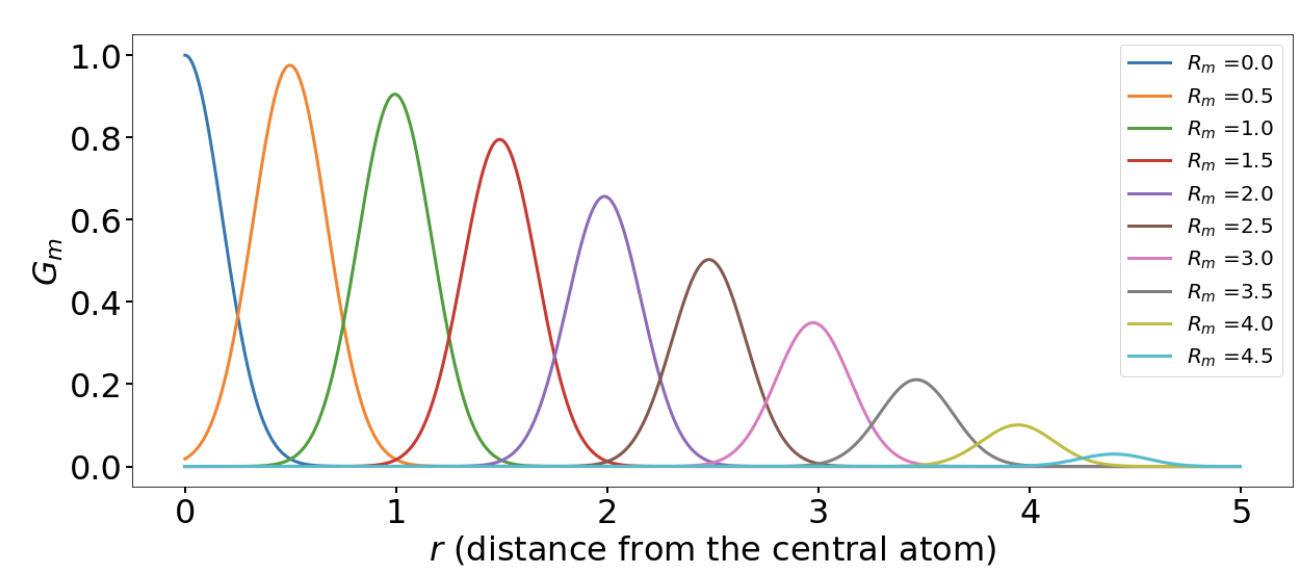

Radial part of the G vector for _ith_ atom in the unit cell is calculated via :


$\displaystyle \Large G_{m;i}^{\rm Rad} =  \sum_{i \ne j}^\text{All neighboring atoms}
           e^{-\eta_m \left(r_{ij} - R_m\right)^2}
          f_c(r_{ij}) $

where $\eta_m$ and $R_m$ determine the shape and center of the "mth" sampler Gaussian, $f_c$ is a cutoff function to ensure smooth decay. This equation gives the value of the _mth_ dimension of the G vector.  


The resulting descriptor is very similar to a discretized radial/angular distribution function, or a _histogram_ of each atomic environment density. Number of sampling functions determines the number of "bins" used in the historgram.

Here is the Silicon radial G vector with 32 equally spaced samplers for liquid and diamond phases:
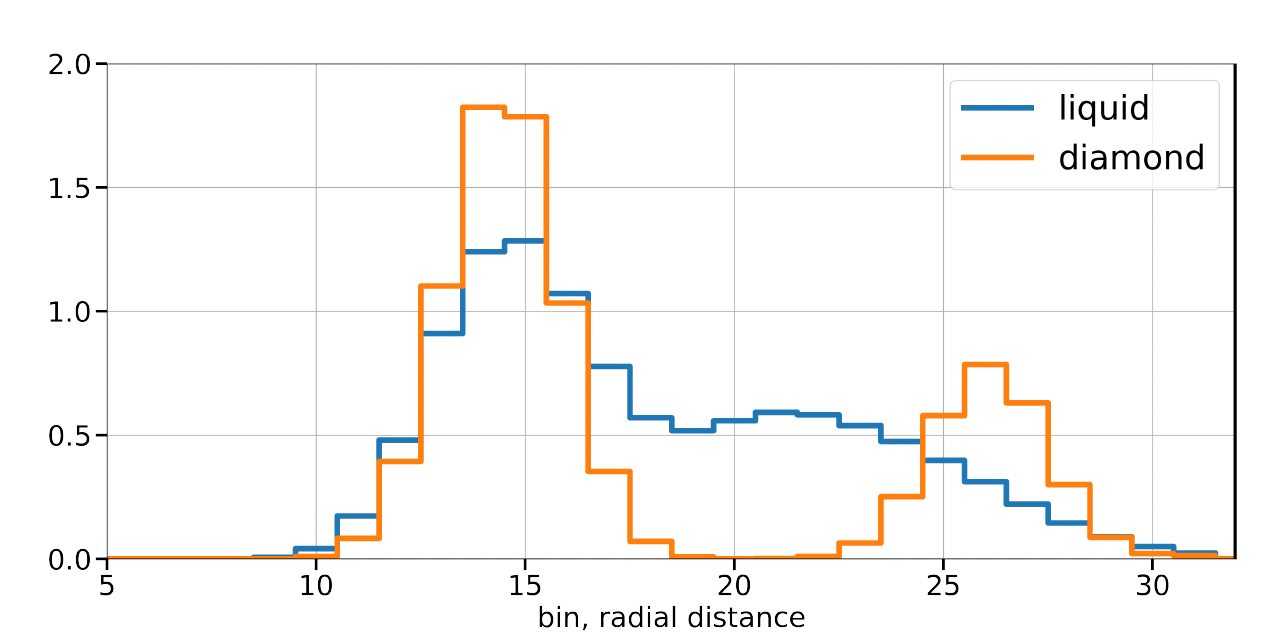

The angular descriptor is similarly made up of sampler functions which sample the  local three-body configurations involving the central atom at different angles. The angular descriptor also incorporates the radial distances as follows:

$ \displaystyle
\Large G_{n,m;i}^{\rm Ang} =  2 \sum_{j,k \ne i}^\text{All neighboring atoms} \left(\frac{1 + \cos( \Theta_{jik} - \Theta_n)}{2}\right)^\xi $

$\displaystyle
\Large \qquad \qquad \qquad \qquad \times e^{-\eta \left(\frac{r_{ij} + r_{ik}}{2} - R_m\right)^2}
          f_c(r_{ij})f_c(r_{ik})$

The angular descriptor can distinguish environments in both angular and radial differences by using radial binning for the average bond length of each 3-body angle:
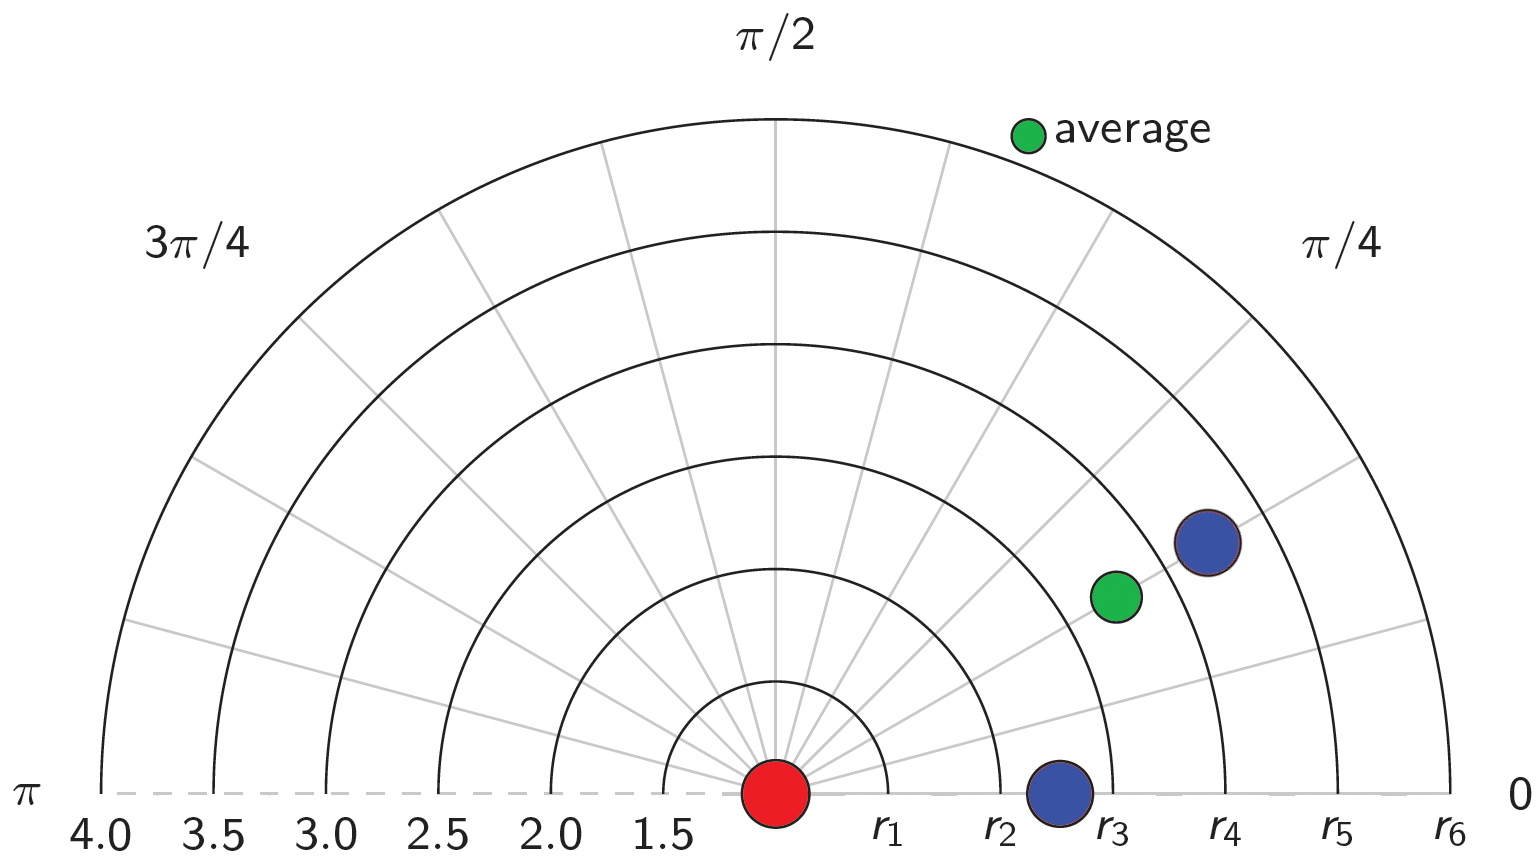

The resulting descriptor for Silicon in different phases looks like the following:
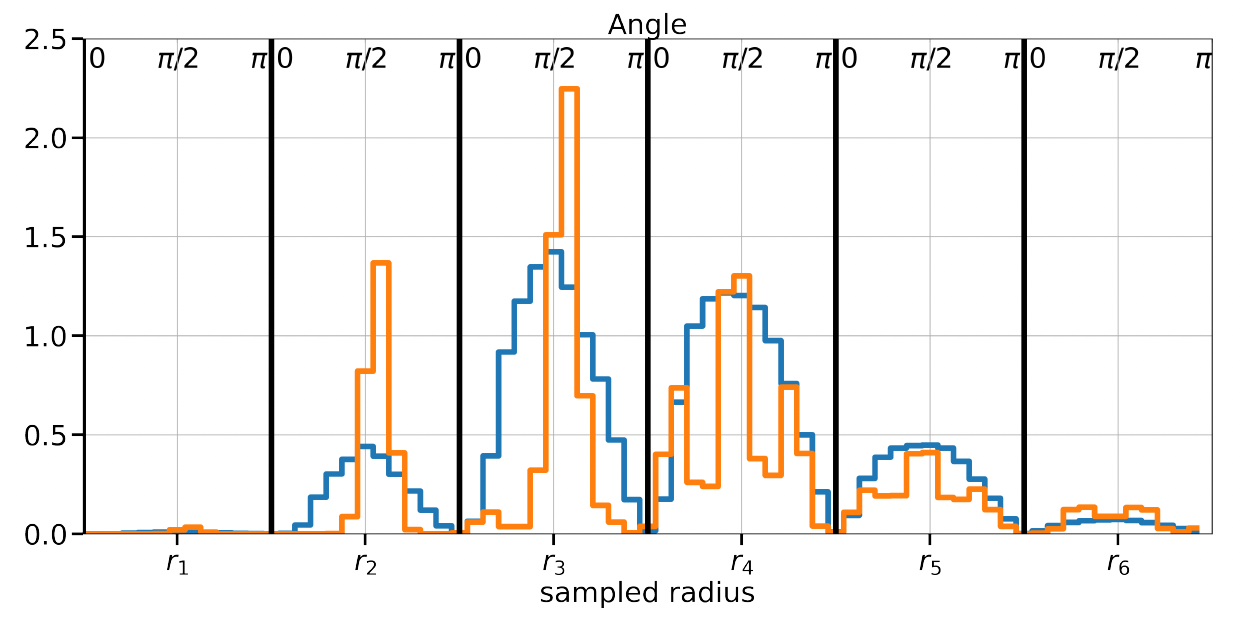

The equations above apply to the case of single atomic species. In the case of multiple species there are a few strategies. One we will see today is building the vectors in a species-resolved way, i.e.

$\displaystyle \Large G_{m,s;i}^{\rm R} =  \sum_{i \ne j}^\text{All atoms of species s}
           e^{-\eta \left(r_{ij} - R_m\right)^2}
          f_c(r_{ij})$

and

$\displaystyle \Large G_{n,m,s1, s2;i}^{\rm A} =  2 \sum_{j,k \ne i}^\text{All atom of kind s1, s2 } \left(\frac{1 + \cos( \Theta_{jik} - \Theta_n)}{2}\right)^\xi  $

$\displaystyle
\Large \qquad \qquad \qquad \qquad \qquad \qquad  
\times e^{-\eta \left(\frac{r_{ij} + r_{ik}}{2} - R_m\right)^2}
          f_c(r_{ij})f_c(r_{ik})$


Now we have seen what the G-vectors are so let us build a few from the molecular configurations we have previously generated the example json files for.

First order of business is to determine the parameters of the G-vector, e.g. Gaussian centers and widths. We have selected some realistic ones for you below.

In [10]:
units = 'angstrom'
# radial
rc_rad = 4.6
rs0_rad = 0
rsn_rad = 16
rsst_rad = (rc_rad - rs0_rad) / rsn_rad
rs_rad = np.arange(rs0_rad, rc_rad, rsst_rad)
eta_rad = 16
eta_rad = np.tile(np.asarray(eta_rad), len(rs_rad))

# angular
thetasn = 10
step_theta = np.pi / thetasn
thetas = np.arange(0, np.pi, step_theta) + .5 * step_theta
zeta = 50
zeta = np.tile(np.asarray(zeta), len(thetas))

# radial_angular components
rc_ang = 3.1
rs0_ang = 0
rsn_ang = 4
rsst_ang = (rc_ang - rs0_ang) / rsn_ang
rs_ang = np.arange(rs0_ang, rc_ang, rsst_ang)
eta_ang = 6.0
eta_ang = np.tile(np.asarray(eta_ang), len(rs_ang))

Next, we will use the modified-Behler-Parrinello gvector calculator function in the ``gvect_calculator.py`` script. We should first send to it the parameters we defined above:

In [11]:
from panna.gvector import GvectmBP
species = 'H,O'
gvect_func = GvectmBP(species=species)
nsp = len(species.split(','))

gvect_func.units = units
gvect_func.update_parameter('Rc_rad', rc_rad)
gvect_func.update_parameter('Rs_rad', rs_rad)
gvect_func.update_parameter('eta_rad', eta_rad)
gvect_func.update_parameter('Thetas', thetas)
gvect_func.update_parameter('zeta', zeta)
gvect_func.update_parameter('Rc_ang', rc_ang)
gvect_func.update_parameter('Rs_ang', rs_ang)
gvect_func.update_parameter('eta_ang', eta_ang)

print("Number of species is: {}".format(nsp))

print("Size of the radial part is: {}".format(len(rs_rad) * nsp))

print("Size of the angular part \
for each species permutation is: {}".format(len(thetas)*len(rs_ang)))

print("There are {} 3-body species permutations \
hence the total size of the angularpart is: {} ".format((nsp*nsp+nsp)//2 , len(thetas)*len(rs_ang) *(nsp*nsp+nsp)//2 ))

print("The total size of the G-vector with these parameters is: {}".
        format(gvect_func.gsize))



Number of species is: 2
Size of the radial part is: 32
Size of the angular part for each species permutation is: 40
There are 3 3-body species permutations hence the total size of the angularpart is: 120 
The total size of the G-vector with these parameters is: 152


Now we will send to the gvector calculator the configuration information in the example json file:

In [12]:
# Below ensures the example file is complete, and makes some unit conversions if needed
from panna.lib import ExampleJsonWrapper
eg = ExampleJsonWrapper(panna_dir+'/doc/tutorial/myexamples/10.example', ['H','O'])

#Below calculates the gvector from the given example file:
gvector_data = gvect_func(eg.key, eg.positions, eg.species_indexes, eg.lattice_vectors, )

#Let's print out some elements of the gvector
print(type(gvector_data['Gvect']))
Gvect_np = np.array(gvector_data['Gvect'])
Gvect_np.shape

# this is the input to the neural network

<class 'list'>


(3, 152)

In [13]:
# The supervised learning will use the following information about the configuration:
print("Tot Energy in eV: \n", eg.ev_energy,"\n","Forces in eV/Angstrom:  \n", eg.forces)


Tot Energy in eV: 
 -487.1204032868126 
 Forces in eV/Angstrom:  
 [[-0.09398522 -0.05833588  0.        ]
 [ 2.86992976 -4.57242436  0.        ]
 [-2.77594454  4.63076024  0.        ]]


The standard way we would construct Gvectors for multiple configurations is via the python script, and not notebooks.

The script requires the parameters we defined above, and you can define further parameters, for example, the kind of symmetry function you would like to build and # of threads to be used in parallelization. See below how to provide this information via a configuration file.

```
  python path_to_panna/gvect_calculator.py --config tutorial/input_files/mygvect_sample.ini
```

By default this script builds the gvectors for all the configurations it finds in a directory, and writes the information of gvectors, energy and forces to one file for each atomic configuration. The files are in binary format with ``.bin`` extension.

Below we construct the gvectors for all the examples we gathered so far (there are 4 species H,C,N,O and the Gvect size is 384 per species)

In [14]:
!cat {panna_cmdir+'/doc/tutorial/input_files/mygvect_sample.ini'}

[IO_INFORMATION]
input_json_dir = ./myexamples
output_gvect_dir = ./gvectors
log_dir = .

[SYMMETRY_FUNCTION]
type = mBP
species = H, C, N, O

[PARALLELIZATION]
number_of_process = 1

[GVECT_PARAMETERS]
# PANNA expects all the parameters in Angstrom and eV  by default
#if you would like to define Gvect parameters in other units
# you need to explicitly define the unit here
gvect_parameters_unit = angstrom
# RADIAL_COMPONENTS
# radial exponent Angstrom**2
eta_rad = 16
# cutoff Angstrom
Rc_rad = 4.6 
# bias for R_s, Angstrom
Rs0_rad = 0.5
# number or R_s radial
RsN_rad = 16

# ANGULAR_COMPONENTS
# radial exponent  Angstrom**2
eta_ang = 6.0
# cutoff
Rc_ang = 3.1
# bias for angular R_s, Angstrom
Rs0_ang = 0.5
# step size for angular R_s, Angstrom
Rsst_ang = 0.65
# number or R_s angular
RsN_ang = 4
# angular exponent
zeta = 50.0
# number or theta_s
ThetasN = 8


In [15]:
if os.path.exists(panna_dir+'/doc/tutorial/gvect_already_computed.dat'):
  os.remove(panna_dir+'/doc/tutorial/gvect_already_computed.dat')
!cd {panna_cmdir+'/doc/tutorial'}; python {panna_cmdir+'/src/panna/gvect_calculator.py'} --config input_files/mygvect_sample.ini

2025-01-15 16:03:27.316724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - PBC will be determined by lattice parameters in the json file for each example
INFO - Radial Gaussian centers are set by Rs0_rad, Rc_rad, RsN_rad
INFO - Angular descriptor centers are set by ThetasN
INFO - Radial-angular Gaussian centers are set by Rs0_ang, Rc_ang, RsN_ang
INFO - g type: mBP
INFO - g DOI: 10.1016/j.cpc.2020.107402
INFO - g size: 384
INFO - computed keys 0/14
INFO - --start--
INFO - ----run----
INFO - start parallel computation, 13 to go
INFO - ----run----
INFO - start parallel computation, 12 to go
INFO - ----run----
INFO - start parallel computation, 11 to go
INFO - ----run---

In [16]:
!ls {panna_cmdir+'/doc/tutorial/gvectors/'}

0.bin	1.bin  3.bin  5.bin  7.bin  9.bin		ANI_001c05be86.bin
10.bin	2.bin  4.bin  6.bin  8.bin  ANI_0008adfa55.bin	ANI_001ebe6ca2.bin


### PART 1c - Packing the binary input files into TFR files

Once the binary files are created, we package them for a very efficient read-in process in a format called TensorFlow Record (tfr), which allows the underlying TensorFlow engine to rapidly load a lot of data during training. This comes very handy with mini-batch training on large amounts of data. To convert the binary gvectors to tfr’s, we run the script ``panna_tfr_packer.py`` with an appropriate configuration file.

See what a sample configuration file for this script looks like, we provide a working input file in ``input_files/tfr_sample.ini``.

In [17]:
!cat {panna_cmdir+'/doc/tutorial/input_files/tfr_sample.ini'}

[IO_INFORMATION]
input_dir = ./gvectors
output_dir = ./tfr
elements_per_file = 10
prefix = train

[CONTENT_INFORMATION]
n_species = 4



In short, we give the location of the binary files to be packaged, how many files we want to pack together (be mindful of the size, each tfr being ~100MB seems to work best with most HPCs.

Let us pack the gvectors we have generated in the previous step of the tutorial into tfr files (this assumes you have not deleted the gvectors folder):
```
  python path_to_panna/tfr_packer.py --config ./input_files/tfr_sample.ini
```
This will create our input files for training (or evaluation) in the specified folder (mytfr for this tutorial) as a certain number of .tfrecord files, with a progressive identification number.

In [18]:
!cd {panna_cmdir+'/doc/tutorial'}; python {panna_cmdir+'/src/panna/tfr_packer.py'} --config input_files/tfr_sample.ini

2025-01-15 16:07:18.381353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - file 1/2
INFO - file already computed
INFO - file 2/2
INFO - file already computed


In [19]:
!ls -alth {panna_cmdir+'/doc/tutorial/tfr'}

total 86K
-rw------- 1 root root 57K Jan 13 16:26 train-1-2.tfrecord
-rw------- 1 root root 29K Jan 13 16:26 train-2-2.tfrecord


#### In summary:
The data preparation step has three substeps and each is governed by a different script:

- ``parser_XXX.py`` (extracting the relevant information from DFT or other sources) --> outputs ``.example`` json files
- ``gvect_calculator.py`` (converting this information into neural network input) --> outputs ``.bin`` binary files (by default)
- ``tfr_packer.py`` (packaging the binary gvector files into efficient TF-ready format) --> outputs ``.tfr`` TF record files

#### Now the input data is ready, next step is training the NN!

In [20]:
# Run this to cleanup the tutorial directory
!cd {panna_cmdir+'/doc/tutorial'}; rm -rf gvect_already_computed.dat gvectors myexamples tf.log tfr